In [1]:
from dariah_topics import preprocessing as pre
from dariah_topics import visualization as visual
from dariah_topics import evaluation

c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\funcy\decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\funcy\decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\funcy\decorators.py:56: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  spec = inspect.getargspec(func)
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\funcy\decorators.py

## Preprocessing

#### Liste mit Dateinamen erzeugen

In [2]:
path_txt = "corpus_txt"
#path_txt = "grenzbote_plain/*/"
#path_txt = "wiki/"

doclist_txt = pre.create_document_list(path_txt)
assert doclist_txt, "No documents found"
doclist_txt[:5]

c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\IPython\core\formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\IPython\core\formatters.py:98: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\IPython\core\formatters.py:677: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\IPython\core\formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.

['corpus_txt\\Doyle_AScandalinBohemia.txt',
 'corpus_txt\\Doyle_AStudyinScarlet.txt',
 'corpus_txt\\Doyle_TheHoundoftheBaskervilles.txt',
 'corpus_txt\\Doyle_TheSignoftheFour.txt',
 'corpus_txt\\Howard_GodsoftheNorth.txt']

#####  Liste mit Dokumentenlabels erzeugen - (Funktion wird durch Thorsten's generischere Funktion ersetzt)

In [3]:
doc_labels = list(pre.get_labels(doclist_txt))
doc_labels[:5]

['Doyle_AScandalinBohemia',
 'Doyle_AStudyinScarlet',
 'Doyle_TheHoundoftheBaskervilles',
 'Doyle_TheSignoftheFour',
 'Howard_GodsoftheNorth']

#### Corpus laden

In [4]:
corpus_txt = pre.read_from_txt(doclist_txt)

#### Tokenisieren

In [5]:
doc_tokens = [list(pre.tokenize(txt)) for txt in list(corpus_txt)]

#### Create Dictionaries

In [6]:
id_types, doc_ids = pre.create_dictionaries(doc_labels, doc_tokens)

#### Sparse BOW Model

In [7]:
sparse_bow = pre.create_mm(doc_labels, doc_tokens, id_types, doc_ids)

In [8]:
sparse_bow[:5]

0
doc_id token_id    
1      8193       2
       16912      1
       4102       1
       8199      27
       9          4

## Topic Modeling with Gensim

##### Saving Sparse BOW

In [9]:
pre.save_bow_mm(sparse_bow, "gensim_txt")

#### Import Market Matrix

In [10]:
from gensim.models import LdaModel
from gensim.corpora import MmCorpus

In [11]:
mm = MmCorpus("gensim_txt.mm")

In [12]:
doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

##### Remove Features

type2id = {value : key for key, value in id_types.items()}
sparse_bow_collapsed = sparse_bow.groupby(sparse_bow.index.get_level_values('token_id')).sum()

sparse_bow_hapax = sparse_bow_collapsed.loc[sparse_bow_collapsed[0] == 1]
hapax = [type2id[key] for key in sparse_bow_hapax.index.get_level_values('token_id')]

len(hapax)

In [13]:
import os.path
basepath = os.path.abspath('.')

with open(os.path.join(basepath, "tutorial_supplementals", "stopwords", "de.txt"), 'r', encoding = 'utf-8') as f: 
    stopword_list = f.read().split('\n')
    
stopword_list = set(stopword_list)

In [14]:
hapax_from_remove = pre.find_hapax(sparse_bow, id_types)
stopwords_from_remove = pre.find_stopwords(sparse_bow, id_types, mfw=75)

#features_to_be_removed = set(hapax_from_remove + stopwords_from_remove)
features_to_be_removed = stopwords_from_remove

sparse_bow_short = pre.remove_features(sparse_bow, id_types, features_to_be_removed)

In [15]:
len(features_to_be_removed)

75

In [16]:
pre.save_bow_mm(sparse_bow_short, "gensim_txt")

In [17]:
mm = MmCorpus("gensim_txt.mm")

#### Convert sparse_bow to list of (doc, tokens) tuples (like doc2bow)

In [18]:
doc2bow_list = []

for doc in sparse_bow_short.index.groupby(sparse_bow_short.index.get_level_values('doc_id')):
    temp = [(token, count) for token, count in zip(sparse_bow_short.loc[doc].index, sparse_bow_short.loc[doc][0])]
    doc2bow_list.append(temp)

In [19]:
len(doc2bow_list)

17

In [20]:
#model = LdaModel(corpus=mm, id2word=type2id, num_topics=60, alpha = "symmetric", passes = 10) #import momentan in visual 
# -> da ich mir noch nicht sicher bin, welche Funktionen in das tm_gensim.py sollen
model = LdaModel(corpus=mm, id2word=type2id, num_topics=20, passes = 10, iterations = 20)

In [21]:
model.get_document_topics(doc2bow_list[1])

[(4, 0.011852930500708986),
 (6, 0.198984677199222),
 (11, 0.020764385935290782),
 (12, 0.24928185282788989),
 (14, 0.051512640653829607),
 (15, 0.11414091818038122),
 (16, 0.031774117193653917),
 (17, 0.24232513040124418),
 (19, 0.071289836981532476)]

In [22]:
#Anzeige der keywords für topic n
n = 1
topic_nr_x = model.get_topic_terms(n)

topicTerms = [type2id[i[0]] for i in topic_nr_x]
topicTerms

['corroboration',
 'bicknell',
 'whipple',
 'horrendum',
 'applauded',
 'michaelmas',
 'yeoman',
 'nightly',
 'advantages',
 'half-naked']

In [23]:
#Topic probabilities
topics = model.show_topics(num_topics = 40)
topics

[(0,
  '0.000*"persecuting" + 0.000*"poignant" + 0.000*"intensity" + 0.000*"nightly" + 0.000*"whipple" + 0.000*"terriers" + 0.000*"waste" + 0.000*"corroboration" + 0.000*"mädler’s" + 0.000*"counterparts"'),
 (1,
  '0.000*"corroboration" + 0.000*"bicknell" + 0.000*"whipple" + 0.000*"horrendum" + 0.000*"applauded" + 0.000*"michaelmas" + 0.000*"yeoman" + 0.000*"nightly" + 0.000*"advantages" + 0.000*"half-naked"'),
 (2,
  '0.000*"horrendum" + 0.000*"bicknell" + 0.000*"advantages" + 0.000*"repression" + 0.000*"bearer" + 0.000*"latticed" + 0.000*"mädler’s" + 0.000*"nightly" + 0.000*"restrained" + 0.000*"poignant"'),
 (3,
  '0.000*"repression" + 0.000*"bicknell" + 0.000*"faultless" + 0.000*"nightly" + 0.000*"whipple" + 0.000*"corroboration" + 0.000*"stretch" + 0.000*"bristle" + 0.000*"latticed" + 0.000*"advantages"'),
 (4,
  '0.011*"imagines" + 0.008*"querulous" + 0.006*"yapped" + 0.006*"currency" + 0.006*"miscalculation" + 0.005*"seeing" + 0.004*"tree-roads" + 0.004*"sour" + 0.004*"unparticl

In [24]:
import pandas as pd
import regex as re
def gensim2dataframe(model):
    num_topics = model.num_topics
    topics_df = pd.DataFrame(index = range(num_topics), columns= range(10))

    topics = model.show_topics(num_topics)
    
    for topic_dist in topics:    
        idx = topic_dist[0]
        temp = re.findall(r'\"(.+?)\"', topics[idx][1])
        topics_df.loc[idx] = temp
    
    return topics_df

In [25]:
topics_df = gensim2dataframe(model)

In [26]:
doc_topic = topics_df.T
doc_topic

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,persecuting,corroboration,horrendum,repression,imagines,aeons,bicknell,quote,nightly,applauded,beautifully,fiber,beautifully,horrendum,bicknell,forgets,brutish,stretch,stolidly,feline
1,poignant,bicknell,bicknell,bicknell,querulous,ice-choked,repression,straightest,poignant,progenitors,corroboration,workmanship,whipple,whipple,yeoman,nightly,hum,rotten,flint,beautifully
2,intensity,whipple,advantages,faultless,yapped,dwindled,whole,kicking,bicknell,advantages,persecuting,feline,poignant,mädler’s,repression,mesmeristic,shoggoths,site,might,disjointed
3,nightly,horrendum,repression,nightly,currency,degrees,faultless,burdens,persecuting,nightly,grievously,drenching,grievously,corroboration,drug-created,horrendum,bicknell,carefully,menaced,maid-servants
4,whipple,applauded,bearer,whipple,miscalculation,nine-foot,three-four,sapped,applauded,listens,whipple,wasn't,applauded,beautifully,yielding,fared,grievously,bristle,chained,infatuate
5,terriers,michaelmas,latticed,corroboration,seeing,tush,beside,stealthiness,waste,reserve,feline,homogeneity,repression,cookey's,michaelmas,bristle,position,persecuting,warriors,tree-roads
6,waste,yeoman,mädler’s,stretch,tree-roads,fruitless,corroboration,dance-place,tree-roads,corroboration,nightly,yeoman,terriers,waste,embraces,so-called,metropolis,horrendum,spade,reserve
7,corroboration,nightly,nightly,bristle,sour,admiralty,latticed,rôle,corroboration,faultless,mesmeristic,maid-servants,intensity,persecuting,half-naked,bicknell,commit,miscalculation,spur,whipple
8,mädler’s,advantages,restrained,latticed,unparticled,butcher-knife,magicians,rapier,intensity,waste,stretch,applauded,jackals,reserve,foamy,advantages,horrendum,mädler’s,carefully,lamed
9,counterparts,half-naked,poignant,advantages,defiant,stoopids,nightly,absconded,terriers,terriers,terriers,whipple,tortured,yeoman,micefield,singing-out,yeoman,poignant,stretch,horrendum


## Visualisierung 

In [27]:
'''lda_model = 'out_easy/corpus.lda'
corpus = 'out_easy/corpus.mm'
dictionary = 'out_easy/corpus.dict'
doc_labels = 'out_easy/corpus_doclabels.txt'
interactive  = False

vis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)'''

"lda_model = 'out_easy/corpus.lda'\ncorpus = 'out_easy/corpus.mm'\ndictionary = 'out_easy/corpus.dict'\ndoc_labels = 'out_easy/corpus_doclabels.txt'\ninteractive  = False\n\nvis = visual.Visualization(lda_model, corpus, dictionary, doc_labels, interactive)"

##### Create a document-topic matrix (that is a pandas data frame actually)

In [28]:
doc_topic = visual.create_doc_topic(mm, model, doc_labels)

##### Visualize document-topic matrix

c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\ipykernel\pylab\config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\ipykernel\pylab\config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-packages\ipykernel\pylab\config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
c:\users\philip\appdata\local\programs\python\python35-32\lib\site-package

<module 'matplotlib.pyplot' from 'c:\\users\\philip\\appdata\\local\\programs\\python\\python35-32\\lib\\site-packages\\matplotlib\\pyplot.py'>

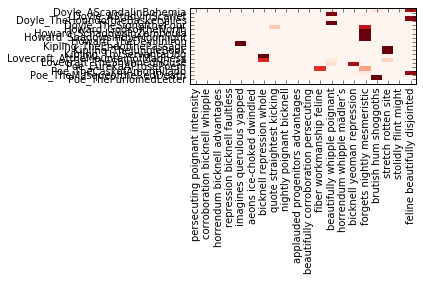

In [29]:
%matplotlib inline
visual.doc_topic_heatmap(doc_topic)

##### Visualize topic distribution in a single document

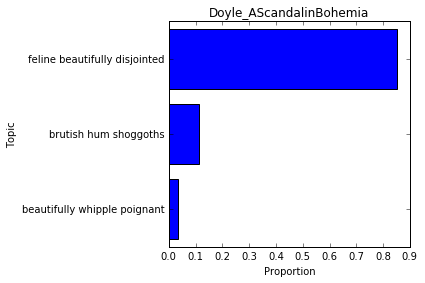

In [30]:
visual.plot_doc_topics(doc_topic, 0)

![success](http://cdn2.hubspot.net/hub/128506/file-446943132-jpg/images/computer_woman_success.jpg)